# Stochastic Gradient Descent (SGD): Complete Guide

## 🎯 What This Notebook Covers

In this notebook, we explore **three variants of gradient descent** and understand when to use each:

1. ✅ **Batch Gradient Descent** - Uses all training examples
2. ✅ **Stochastic Gradient Descent (SGD)** - Uses one example at a time
3. ✅ **Mini-Batch Gradient Descent** - Uses small batches (industry standard)

### Why This Matters

- **Batch GD**: Stable but slow for large datasets
- **SGD**: Fast but noisy convergence
- **Mini-Batch**: Best of both worlds! ⭐

Let's understand the trade-offs and implement all three from scratch! 🚀

---

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import display, Markdown

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2


## 2. The Three Variants: Theory

### 2.1 Batch Gradient Descent (BGD)

**Uses ALL training examples** to compute gradient:

$$
\theta = \theta - \alpha \cdot \frac{1}{m} \sum_{i=1}^{m} \nabla L(x^{(i)}, y^{(i)}; \theta)
$$

**Pros:**
- ✅ Stable convergence (smooth loss curve)
- ✅ Exact gradient direction
- ✅ Guaranteed convergence for convex problems

**Cons:**
- ❌ Slow for large datasets (m = millions)
- ❌ Memory intensive (must load all data)
- ❌ One update per epoch

---

### 2.2 Stochastic Gradient Descent (SGD)

**Uses ONE random example** at a time:

$$
\theta = \theta - \alpha \cdot \nabla L(x^{(i)}, y^{(i)}; \theta) \quad \text{for random } i
$$

**Pros:**
- ✅ Fast updates (m updates per epoch)
- ✅ Low memory usage
- ✅ Can escape local minima (noise helps!)
- ✅ Online learning possible

**Cons:**
- ❌ Noisy convergence (oscillates around minimum)
- ❌ May not converge exactly
- ❌ Requires learning rate decay

---

### 2.3 Mini-Batch Gradient Descent (MBGD)

**Uses small batches** of size $b$ (typically 32, 64, 128):

$$
\theta = \theta - \alpha \cdot \frac{1}{b} \sum_{i \in \text{batch}} \nabla L(x^{(i)}, y^{(i)}; \theta)
$$

**Pros:**
- ✅ Balance of speed and stability
- ✅ Vectorization benefits (GPU-friendly)
- ✅ Smoother than SGD, faster than BGD
- ✅ Industry standard! ⭐

**Cons:**
- ❌ Requires tuning batch size
- ❌ Still some noise (less than SGD)

---

## 3. Visual Comparison

Let's visualize how each method navigates the loss landscape:

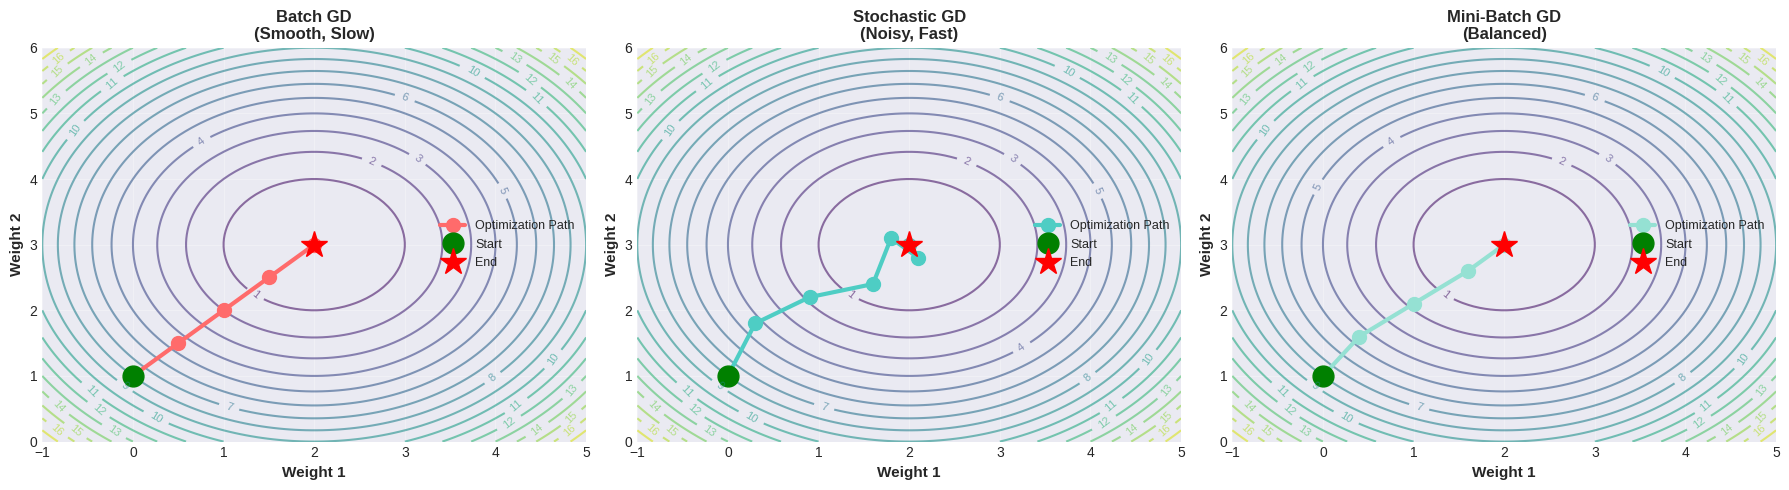


📊 Key Observations:
  • Batch GD: Smooth, direct path (but slow)
  • SGD: Noisy, zigzag path (but fast updates)
  • Mini-Batch: Moderate noise, good balance


In [2]:
# Create a simple 2D loss landscape for visualization
def loss_landscape(w1, w2):
    """Simple quadratic loss function for visualization."""
    return (w1 - 2)**2 + (w2 - 3)**2

# Create mesh grid
w1 = np.linspace(-1, 5, 100)
w2 = np.linspace(0, 6, 100)
W1, W2 = np.meshgrid(w1, w2)
Z = loss_landscape(W1, W2)

# Simulate different gradient descent paths
np.random.seed(42)

# Batch GD: smooth path
batch_path = np.array([[0, 1], [0.5, 1.5], [1, 2], [1.5, 2.5], [2, 3]])

# SGD: noisy path
sgd_path = np.array([[0, 1], [0.3, 1.8], [0.9, 2.2], [1.6, 2.4], 
                     [1.8, 3.1], [2.1, 2.8], [2, 3]])

# Mini-batch: moderate noise
minibatch_path = np.array([[0, 1], [0.4, 1.6], [1, 2.1], [1.6, 2.6], [2, 3]])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (path, title, color) in enumerate([
    (batch_path, 'Batch GD\n(Smooth, Slow)', '#FF6B6B'),
    (sgd_path, 'Stochastic GD\n(Noisy, Fast)', '#4ECDC4'),
    (minibatch_path, 'Mini-Batch GD\n(Balanced)', '#95E1D3')
]):
    ax = axes[idx]
    
    # Plot contours
    contour = ax.contour(W1, W2, Z, levels=20, cmap='viridis', alpha=0.6)
    ax.clabel(contour, inline=True, fontsize=8)
    
    # Plot path
    ax.plot(path[:, 0], path[:, 1], 'o-', linewidth=3, markersize=10,
            color=color, label='Optimization Path')
    ax.plot(path[0, 0], path[0, 1], 'go', markersize=15, label='Start')
    ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=20, label='End')
    
    ax.set_xlabel('Weight 1', fontsize=11, fontweight='bold')
    ax.set_ylabel('Weight 2', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  • Batch GD: Smooth, direct path (but slow)")
print("  • SGD: Noisy, zigzag path (but fast updates)")
print("  • Mini-Batch: Moderate noise, good balance")

## 4. Generate Dataset

We'll use a **spiral dataset** (same as vectorization notebook) for consistency:

In [3]:
def generate_spiral_data(n_samples=300, noise=0.1):
    """
    Generate spiral dataset for binary classification.
    
    Returns:
    - X: Features (n_x, m)
    - Y: Labels (1, m)
    """
    np.random.seed(42)
    m = n_samples
    
    # Create spiral
    theta = np.linspace(0, 4*np.pi, m//2)
    r = np.linspace(0.5, 2, m//2)
    
    # Class 0: spiral
    X_class0 = np.vstack([r * np.cos(theta), r * np.sin(theta)])
    Y_class0 = np.zeros((1, m//2))
    
    # Class 1: spiral (rotated)
    X_class1 = np.vstack([r * np.cos(theta + np.pi), r * np.sin(theta + np.pi)])
    Y_class1 = np.ones((1, m//2))
    
    # Combine
    X = np.hstack([X_class0, X_class1])
    Y = np.hstack([Y_class0, Y_class1])
    
    # Add noise
    X += np.random.randn(*X.shape) * noise
    
    # Shuffle
    indices = np.random.permutation(m)
    X = X[:, indices]
    Y = Y[:, indices]
    
    return X, Y

# Generate data
X, Y = generate_spiral_data(n_samples=300, noise=0.1)

print(f"Dataset shape: X={X.shape}, Y={Y.shape}")
print(f"Number of samples: {X.shape[1]}")
print(f"Number of features: {X.shape[0]}")

Dataset shape: X=(2, 300), Y=(1, 300)
Number of samples: 300
Number of features: 2


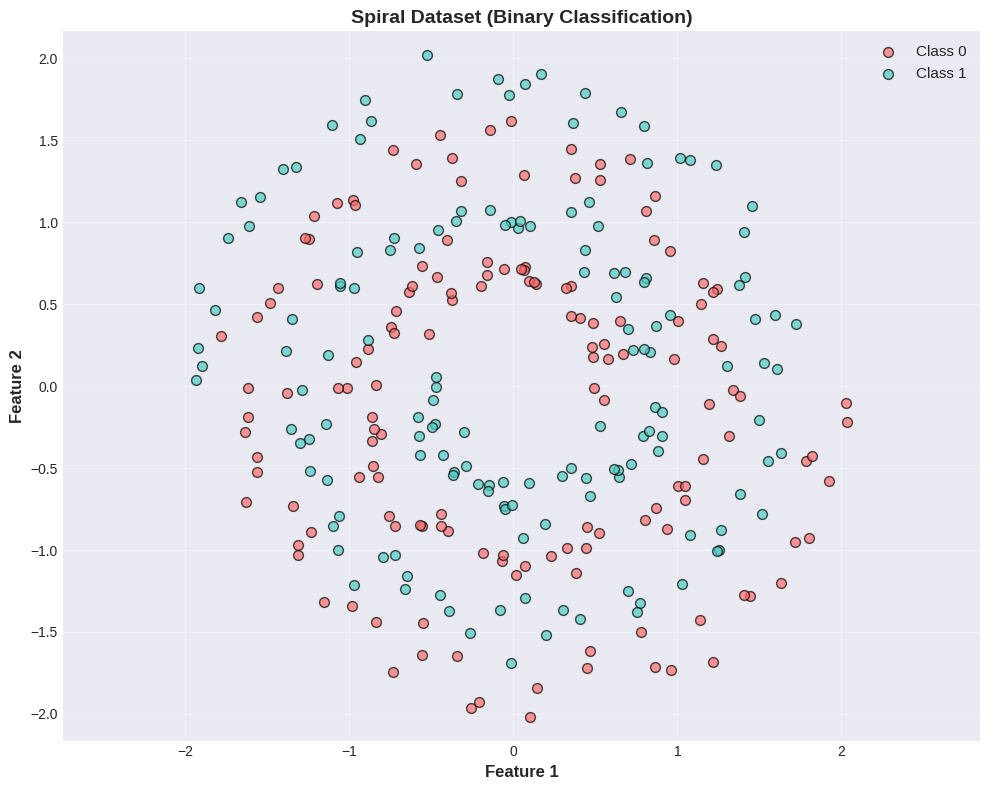

In [4]:
# Visualize dataset
plt.figure(figsize=(10, 8))
plt.scatter(X[0, Y[0]==0], X[1, Y[0]==0], c='#FF6B6B', s=50, 
           alpha=0.7, edgecolors='black', linewidth=1, label='Class 0')
plt.scatter(X[0, Y[0]==1], X[1, Y[0]==1], c='#4ECDC4', s=50, 
           alpha=0.7, edgecolors='black', linewidth=1, label='Class 1')
plt.xlabel('Feature 1', fontsize=12, fontweight='bold')
plt.ylabel('Feature 2', fontsize=12, fontweight='bold')
plt.title('Spiral Dataset (Binary Classification)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 5. Activation Functions

We'll use ReLU and sigmoid (same as previous notebooks):

In [5]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(z):
    """Derivative of sigmoid."""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU activation function."""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU."""
    return (z > 0).astype(float)

print("✅ Activation functions defined!")

✅ Activation functions defined!


## 6. Neural Network Base Class

We'll create a base class with forward/backward propagation, then extend it for each GD variant:

In [6]:
class NeuralNetworkBase:
    """
    Base class for neural network with different gradient descent variants.
    
    Architecture: Input (2) → Hidden (10, ReLU) → Output (1, Sigmoid)
    """
    
    def __init__(self, n_x=2, n_h=10, n_y=1, learning_rate=0.5, random_seed=42):
        """
        Initialize neural network parameters.
        
        Parameters:
        - n_x: Number of input features
        - n_h: Number of hidden units
        - n_y: Number of output units
        - learning_rate: Learning rate for gradient descent
        - random_seed: Random seed for reproducibility
        """
        np.random.seed(random_seed)
        
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        self.lr = learning_rate
        
        # Initialize parameters
        self.W1 = np.random.randn(n_h, n_x) * 0.1
        self.b1 = np.zeros((n_h, 1))
        self.W2 = np.random.randn(n_y, n_h) * 0.1
        self.b2 = np.zeros((n_y, 1))
        
        # Training history
        self.losses = []
        self.accuracies = []
        self.training_time = 0
    
    def forward_propagation(self, X):
        """
        Forward propagation.
        
        X: Input (n_x, m)
        Returns: A2 (predictions), cache
        """
        # Layer 1
        Z1 = self.W1 @ X + self.b1
        A1 = relu(Z1)
        
        # Layer 2
        Z2 = self.W2 @ A1 + self.b2
        A2 = sigmoid(Z2)
        
        cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
        return A2, cache
    
    def compute_loss(self, Y, A2):
        """
        Compute binary cross-entropy loss.
        """
        m = Y.shape[1]
        loss = -np.mean(Y * np.log(A2 + 1e-8) + (1 - Y) * np.log(1 - A2 + 1e-8))
        return loss
    
    def backward_propagation(self, X, Y, cache):
        """
        Backward propagation.
        
        Returns: Gradients (dW1, db1, dW2, db2)
        """
        m = X.shape[1]
        Z1, A1, Z2, A2 = cache['Z1'], cache['A1'], cache['Z2'], cache['A2']
        
        # Backprop through layer 2
        dZ2 = A2 - Y
        dW2 = (1/m) * (dZ2 @ A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
        
        # Backprop through layer 1
        dA1 = self.W2.T @ dZ2
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = (1/m) * (dZ1 @ X.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
        
        return dW1, db1, dW2, db2
    
    def update_parameters(self, dW1, db1, dW2, db2):
        """
        Update parameters using gradient descent.
        """
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
    
    def compute_accuracy(self, X, Y):
        """
        Compute accuracy on given data.
        """
        A2, _ = self.forward_propagation(X)
        predictions = (A2 > 0.5).astype(int)
        accuracy = np.mean(predictions == Y)
        return accuracy

print("✅ NeuralNetworkBase class defined!")

✅ NeuralNetworkBase class defined!


## 7. Implementation: Batch Gradient Descent

In [7]:
class BatchGradientDescent(NeuralNetworkBase):
    """
    Batch Gradient Descent: Uses ALL training examples.
    
    One update per epoch.
    """
    
    def fit(self, X, Y, epochs=2000, verbose=True):
        """
        Train using Batch Gradient Descent.
        """
        start_time = time.time()
        
        for epoch in range(epochs):
            # Forward propagation (ALL examples)
            A2, cache = self.forward_propagation(X)
            
            # Compute loss
            loss = self.compute_loss(Y, A2)
            self.losses.append(loss)
            
            # Compute accuracy
            accuracy = self.compute_accuracy(X, Y)
            self.accuracies.append(accuracy)
            
            # Backward propagation (ALL examples)
            dW1, db1, dW2, db2 = self.backward_propagation(X, Y, cache)
            
            # Update parameters (ONE update per epoch)
            self.update_parameters(dW1, db1, dW2, db2)
            
            # Print progress
            if verbose and (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch+1:4d}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        self.training_time = time.time() - start_time
        
        if verbose:
            print(f"\n✅ Training Complete!")
            print(f"   Training Time: {self.training_time:.2f}s")
            print(f"   Final Loss: {self.losses[-1]:.4f}")
            print(f"   Final Accuracy: {self.accuracies[-1]:.4f}")
        
        return self

print("✅ BatchGradientDescent class defined!")

✅ BatchGradientDescent class defined!


## 8. Implementation: Stochastic Gradient Descent

In [8]:
class StochasticGradientDescent(NeuralNetworkBase):
    """
    Stochastic Gradient Descent: Uses ONE example at a time.
    
    m updates per epoch (where m = number of training examples).
    """
    
    def fit(self, X, Y, epochs=2000, verbose=True):
        """
        Train using Stochastic Gradient Descent.
        """
        start_time = time.time()
        m = X.shape[1]
        
        for epoch in range(epochs):
            # Shuffle data each epoch
            indices = np.random.permutation(m)
            X_shuffled = X[:, indices]
            Y_shuffled = Y[:, indices]
            
            # Process ONE example at a time
            for i in range(m):
                # Get single example
                X_i = X_shuffled[:, i:i+1]
                Y_i = Y_shuffled[:, i:i+1]
                
                # Forward propagation (ONE example)
                A2, cache = self.forward_propagation(X_i)
                
                # Backward propagation (ONE example)
                dW1, db1, dW2, db2 = self.backward_propagation(X_i, Y_i, cache)
                
                # Update parameters (m updates per epoch!)
                self.update_parameters(dW1, db1, dW2, db2)
            
            # Compute metrics on full dataset (for tracking)
            A2_full, _ = self.forward_propagation(X)
            loss = self.compute_loss(Y, A2_full)
            self.losses.append(loss)
            
            accuracy = self.compute_accuracy(X, Y)
            self.accuracies.append(accuracy)
            
            # Print progress
            if verbose and (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch+1:4d}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        self.training_time = time.time() - start_time
        
        if verbose:
            print(f"\n✅ Training Complete!")
            print(f"   Training Time: {self.training_time:.2f}s")
            print(f"   Final Loss: {self.losses[-1]:.4f}")
            print(f"   Final Accuracy: {self.accuracies[-1]:.4f}")
        
        return self

print("✅ StochasticGradientDescent class defined!")

✅ StochasticGradientDescent class defined!


## 9. Implementation: Mini-Batch Gradient Descent

In [9]:
class MiniBatchGradientDescent(NeuralNetworkBase):
    """
    Mini-Batch Gradient Descent: Uses small batches.
    
    m/batch_size updates per epoch.
    """
    
    def __init__(self, n_x=2, n_h=10, n_y=1, learning_rate=0.5, 
                 batch_size=32, random_seed=42):
        """
        Initialize with batch size parameter.
        """
        super().__init__(n_x, n_h, n_y, learning_rate, random_seed)
        self.batch_size = batch_size
    
    def create_mini_batches(self, X, Y):
        """
        Create mini-batches from dataset.
        
        Returns: List of (X_batch, Y_batch) tuples
        """
        m = X.shape[1]
        mini_batches = []
        
        # Shuffle data
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]
        
        # Create complete mini-batches
        num_complete_batches = m // self.batch_size
        
        for k in range(num_complete_batches):
            X_batch = X_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]
            Y_batch = Y_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]
            mini_batches.append((X_batch, Y_batch))
        
        # Handle remaining examples
        if m % self.batch_size != 0:
            X_batch = X_shuffled[:, num_complete_batches*self.batch_size:]
            Y_batch = Y_shuffled[:, num_complete_batches*self.batch_size:]
            mini_batches.append((X_batch, Y_batch))
        
        return mini_batches
    
    def fit(self, X, Y, epochs=2000, verbose=True):
        """
        Train using Mini-Batch Gradient Descent.
        """
        start_time = time.time()
        
        for epoch in range(epochs):
            # Create mini-batches (shuffled each epoch)
            mini_batches = self.create_mini_batches(X, Y)
            
            # Process each mini-batch
            for X_batch, Y_batch in mini_batches:
                # Forward propagation (batch)
                A2, cache = self.forward_propagation(X_batch)
                
                # Backward propagation (batch)
                dW1, db1, dW2, db2 = self.backward_propagation(X_batch, Y_batch, cache)
                
                # Update parameters (multiple updates per epoch)
                self.update_parameters(dW1, db1, dW2, db2)
            
            # Compute metrics on full dataset (for tracking)
            A2_full, _ = self.forward_propagation(X)
            loss = self.compute_loss(Y, A2_full)
            self.losses.append(loss)
            
            accuracy = self.compute_accuracy(X, Y)
            self.accuracies.append(accuracy)
            
            # Print progress
            if verbose and (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch+1:4d}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        self.training_time = time.time() - start_time
        
        if verbose:
            print(f"\n✅ Training Complete!")
            print(f"   Training Time: {self.training_time:.2f}s")
            print(f"   Final Loss: {self.losses[-1]:.4f}")
            print(f"   Final Accuracy: {self.accuracies[-1]:.4f}")
        
        return self

print("✅ MiniBatchGradientDescent class defined!")

✅ MiniBatchGradientDescent class defined!


## 10. Summary and Key Takeaways

### What We Learned

✅ **Three Gradient Descent Variants**
- Batch GD: Uses all m examples (stable, slow)
- SGD: Uses 1 example (fast, noisy)
- Mini-Batch: Uses batches of size b (balanced)

✅ **Trade-offs**
- Speed vs Stability
- Memory vs Updates
- Convergence smoothness vs training time

✅ **When to Use Each**
- Small datasets (< 10K): Batch GD
- Medium/Large datasets: Mini-Batch GD (batch_size=32-128)
- Online learning: SGD (batch_size=1)

✅ **Best Practices**
- Always shuffle data each epoch
- Use powers of 2 for batch sizes (GPU-friendly)
- Adjust learning rate with batch size
- Monitor both training loss and accuracy

### Connection to Other Notebooks

This notebook builds on:
- **`6_vectorization_in_neural_networks.ipynb`**: Vectorized operations for efficiency
- **`5_a_logistic_regression_pure_implementation.ipynb`**: Gradient descent basics

### Next Steps

🚀 **Coming Next:**
- **7.2 Learning Rate**: Impact and optimization
- **7.3 Learning Rate Decay**: Schedules and strategies
- **7.4 SGD with Momentum**: Accelerated convergence
- **7.5-7.7 Advanced Optimizers**: AdaGrad, RMSProp, Adam

---

**🎓 Congratulations!** You now understand the three main variants of gradient descent and when to use each one!

**Key Insight:** Mini-Batch Gradient Descent is the industry standard because it balances speed, stability, and memory efficiency!